# Feature Engineering

In [2]:
# DS18 ML Essentials project
# Module 4: Feature Engineering

# Submitted by: Tzvi Eliezer Nir
# mail: tzvienir@gmail.com
# First submission: 27/03/2025

## In this Notebook

In this notebook, we will apply some chosen feature enrichment methods to our data. This will provide our model with additional information to work with — hopefully leading to better results.

We will also engage in feature engineering, which is crucial as it transforms "raw" data into meaningful features that enhance the performance of machine learning models.

### Chosen Features

The new features can be classified into three groups:

#### Parsing the `track_album_release_date` column into more meaningful features:
1. A textbook feature engineering method is to split a datetime into `Year`, `Month`, and `Day`.
2. Additionally, we are working with music! As we all know, music has **decades** (personally, I'm crazy for 2010s EDM and 1990s rock). Categorizing the tracks by their decades could be meaningful.
3. The internet and the streaming industry have drastically changed the way we consume music, which may affect popularity patterns as well. An additional binary column indicating whether or not the track was released in the internet era will be created.

#### Analyzing the `track_name` textual column:

Remember when we moved all free-text columns into `df_text` back in [creating the flat file](01_data_preparation.ipynb)? Now it's the last chance to put it to use before we say goodbye for good. Using **`wordcloud`**, we will analyze the top-mentioned words in the `track_name` column and create dummy (binary) columns to indicate whether the current track contains the frequent word in its name.

#### Considering Artist Followers

The original dataset has no unique identifier for the artists; it simply provides their names as strings. This presents a challenge because there is not much we can do with the names: encoding the artist name will not be meaningful since there are too many of them (10k unique values), and raw text would not help our future model.

So, I took a different approach — the `track_artist` column will be replaced with the number of artist followers, a new feature derived from an external dataset!

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_pickle("./pickle/03_data_cleansing/data_cleansing.pkl")

## Parsing datetime into multiple new features

### Year, Month, Day & Decade

Lets start with the trivial step of separating the datetime to its components + decade. We can drop the original `track_album_release_date` column once we finished:

In [4]:
# Extract year, month, and day from track_album_release_date
df['year'] = df['track_album_release_date'].dt.year
df['month'] = df['track_album_release_date'].dt.month
df['day'] = df['track_album_release_date'].dt.day

# Calculate the decade
df['decade'] = (df['year'] // 10) * 10

# drop the track_album_release_date column
df = df.drop('track_album_release_date', axis=1)

# Display the updated dataframe
df.head()

,track_id,track_artist,track_popularity,track_album_id,danceability,energy,key,loudness,mode,speechiness,...,edm,latin,pop,r&b,rap,rock,year,month,day,decade
0,0017A6SJgTbfQVU2EtsPNo,Barbie's Cradle,41,1srJQ0njEQgd8w4XSqI4JQ,0.682,0.401,2,-10.068,1,0.0236,...,0,0,0,0,0,1,2001,1,1,2000
1,002xjHwzEx66OWFV2IP9dk,RIKA,15,1ficfUnZMaY1QkNp15Slzm,0.582,0.704,5,-6.242,1,0.0347,...,0,0,0,1,0,0,2018,1,26,2010
2,004s3t0ONYlzxII9PLgU6z,Steady Rollin,28,3z04Lb9Dsilqw68SHt6jLB,0.303,0.880,9,-4.739,1,0.0442,...,0,0,0,0,0,1,2017,11,21,2010
3,008MceT31RotUANsKuzy3L,The.madpix.project,24,1Z4ANBVuhTlS6DprlP0m1q,0.659,0.794,10,-5.644,0,0.0540,...,1,0,1,0,0,0,2015,8,7,2010
4,008rk8F6ZxspZT4bUlkIQG,YOSA & TAAR,38,2BuYm9UcKvI0ydXs5JKwt0,0.662,0.838,1,-6.300,1,0.0499,...,0,0,1,0,0,0,2018,11,16,2010


Having the decade in a separate column is nice, but does it really helps? I mean does the mean popularity really varies between decades? Using an ANOVA test answers this exact question:

In [5]:
import scipy.stats as stats

decades = df['decade'].unique()
popularity_by_decade = {decade: df[df['decade'] == decade]['track_popularity'] for decade in decades}

f_statistic, p_value = stats.f_oneway(*popularity_by_decade.values())

print(f"F-statistic: {f_statistic}")
print(f"p-value: {p_value}")

if p_value < 0.05:
    print("There is a significant difference between the group means")
else:
    print("No significant difference between the group means")

F-statistic: 71.52541039234148
p-value: 4.879105730122917e-103
There is a significant difference between the group means


Lets visualize it!

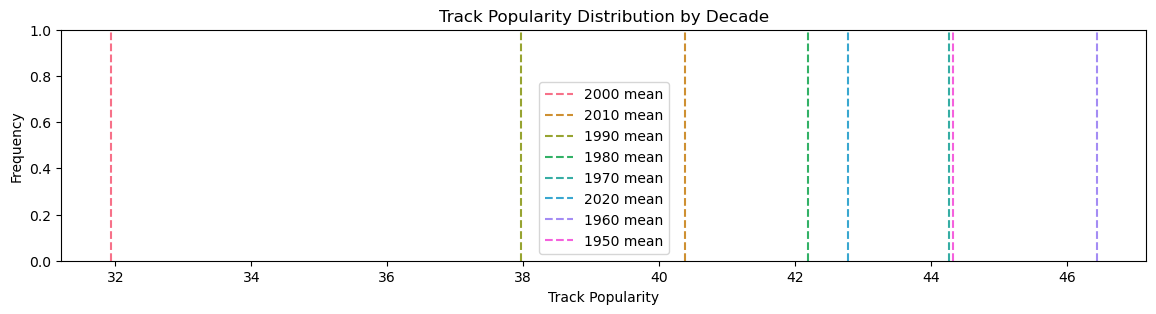

In [6]:
plt.figure(figsize=(14, 3))

# Define a color palette
palette = sns.color_palette("husl", len(decades))

# # Plot histograms for each decade
# for i, decade in enumerate(decades):
#     sns.histplot(popularity_by_decade[decade], kde=False, label=f'{decade}', bins=30, alpha=0.5, color=palette[i])

# Add vertical lines for the mean popularity of each decade
for i, decade in enumerate(decades):
    mean_popularity = popularity_by_decade[decade].mean()
    plt.axvline(mean_popularity, linestyle='--', label=f'{decade} mean', color=palette[i])

plt.title('Track Popularity Distribution by Decade')
plt.xlabel('Track Popularity')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### The internet era

The internet have changed the way we consume music forever, so popularity patterns might have changed as well. But, when exactly shall we draw the line for the internet to take over our life? A good split point for "before/after the internet era" in music could be based on key technological and industry shifts. Here are some possible points:

    1999 – Napster's Launch: Marked the start of widespread digital music sharing, disrupting traditional music distribution.

    2003 – iTunes Store Launch: Made legal digital music downloads mainstream.

    2005 – YouTube's Launch: Video-based music discovery exploded.

    2008 – Spotify's Launch: Streaming became a dominant distribution model.

    2010s – Streaming Overtakes Downloads & CDs: The music industry fully transitioned to streaming as the primary consumption method.

Since this project is about Spotify, I decided out of respect to draw the line at 2008 - Spotify launch year:

F-statistic: 102.82085018856533
p-value: 4.033459112969597e-24
There is a significant difference between the group means


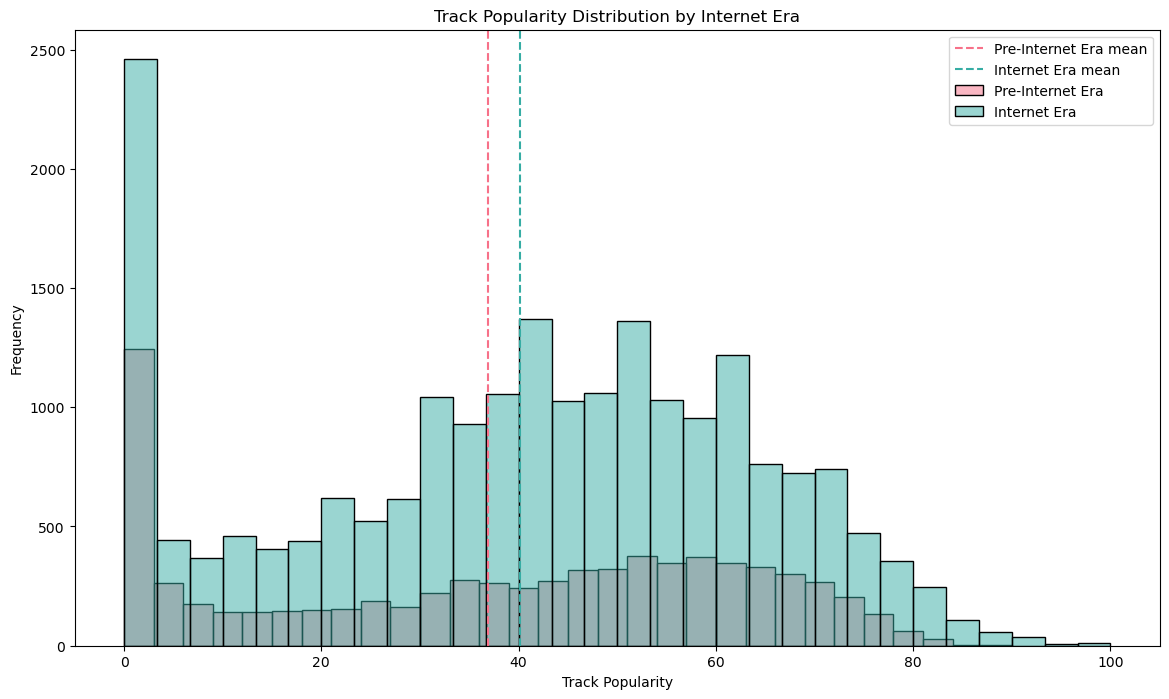

In [7]:
df['released_in_internet_era'] = (df['year'] > 2008).astype(int)

popularity_by_internet_era = {era: df[df['released_in_internet_era'] == era]['track_popularity'] for era in df['released_in_internet_era'].unique()}

f_statistic, p_value = stats.f_oneway(*popularity_by_internet_era.values())

print(f"F-statistic: {f_statistic}")
print(f"p-value: {p_value}")

if p_value < 0.05:
    print("There is a significant difference between the group means")
else:
    print("No significant difference between the group means")

plt.figure(figsize=(14, 8))

# Define a color palette
palette = sns.color_palette("husl", len(popularity_by_internet_era))

# Plot histograms for each era
for i, (era, popularity) in enumerate(popularity_by_internet_era.items()):
    sns.histplot(popularity, kde=False, label=f'{"Internet Era" if era == 1 else "Pre-Internet Era"}', bins=30, alpha=0.5, color=palette[i])

# Add vertical lines for the mean popularity of each era
for i, (era, popularity) in enumerate(popularity_by_internet_era.items()):
    mean_popularity = popularity.mean()
    plt.axvline(mean_popularity, linestyle='--', label=f'{"Internet Era" if era == 1 else "Pre-Internet Era"} mean', color=palette[i])

plt.title('Track Popularity Distribution by Internet Era')
plt.xlabel('Track Popularity')
plt.ylabel('Frequency')
plt.legend()
plt.show()

It seems that track popularity does vary before/after the internet era.

But wait, isn't this contribution redundant since we already created a `Decade` column? well.. yeah it kind of is. But we will let the feature selection step to compare and decide which of the methods to keep, so it won't create bias in the final model.

## Analyzing `track_name` text attributes

Back in [data preparation](01_data_preparation.ipynb) we moved all textual features to a separate dataframe - `df_text`. Now its last call to get some meaningful data out of the textual columns, after this step we will officially say goodbye. 

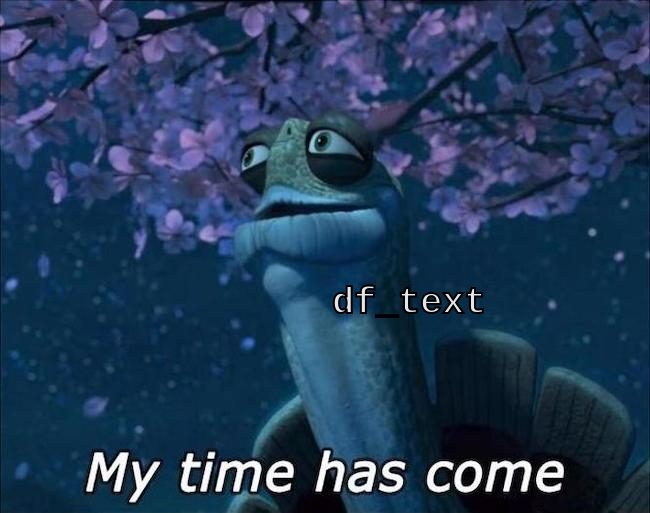

first lets load it, and drop the `playlist_name` we won't need it.

In [8]:
df_text = pd.read_pickle("./pickle/01_data_preparation/df_text.pkl")
df_text = df_text.drop(columns=['playlist_name'])
df_text = df_text.drop_duplicates(subset='track_id')

df_text.describe()

,track_id,track_name,track_album_name
count,28356,28352,28352
unique,28356,23449,19743
top,6f807x0ima9a1j3VPbc7VN,Breathe,Greatest Hits
freq,1,18,135


A good feature engineering will be to analyze popular words in the `track_name`. We will choose the top-5 words, and those words will be used to create five new binary columns - indicating if the current track name contain the popular word.

We will start our analysis using the `wordcloud` package. In addition to get us the answers we want - it also creates nice visualization:

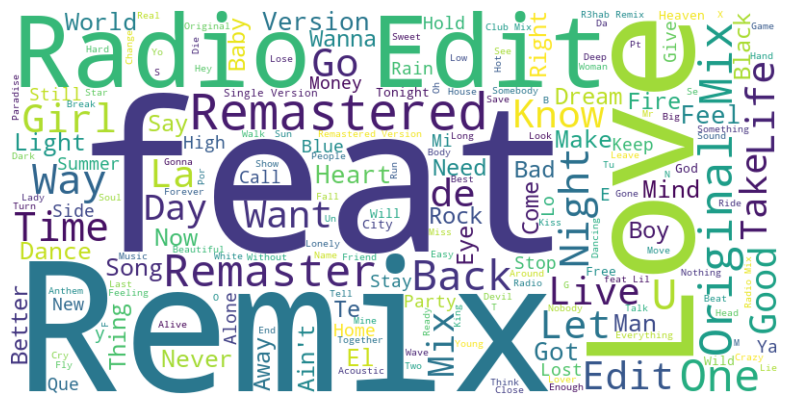

[('feat', 1.0), ('Remix', 0.8182837913628715), ('Love', 0.5339315759955132), ('Radio Edit', 0.2641615255187886), ('Remastered', 0.19125070106561975), ('Original Mix', 0.15872125630959058), ('Remaster', 0.1441390914189568), ('One', 0.14133482893998878), ('U', 0.12226584408300617), ('Back', 0.12114413909141895), ('Way', 0.12002243409983174), ('Night', 0.11721817162086372), ('Time', 0.11497476163768929), ('Go', 0.1076836791923724), ('Life', 0.10600112170499158), ('Let', 0.10487941671340438), ('Girl', 0.10431856421761077), ('Edit', 0.0975883342680875), ('Live', 0.09590577678070668), ('Know', 0.09478407178911946)]


In [9]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all track names into a single string
text = ' '.join(df_text['track_name'].dropna().values)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Get the frequencies of the words
word_frequencies = wordcloud.words_

# Print the top 20 words
top_20_words = sorted(word_frequencies.items(), key=lambda x: x[1], reverse=True)[:20]
print(top_20_words)

To be hones I'm a bit disappointed, I hoped for more meaningful words. *Remix* and *Love* are cool, but the other 3 are kinda boring. But the data is what the data is, so lets continue as planned:

In [10]:
# Create new features based on the top 5 words
for word, _ in top_20_words[:5]:
    df_text[word] = df_text['track_name'].apply(lambda x: 0 if pd.isna(x) else int(word.lower() in x.lower()))

df_text.sample(20)


,track_id,track_name,track_album_name,feat,Remix,Love,Radio Edit,Remastered
15138,4XETUJmrPQnmPd9elRiRE9,Rorschach,Ataraxis,0,0,0,0,0
927,1bSO9nzT5h55OrJO7BbHL2,One Life - VIP Mix,One Life (VIP Mix),0,0,0,0,0
29304,1qZMPmpD1jDcOA7gZ6TCde,One (Your Name) - Radio Edit,One (Your Name),0,0,0,1,0
4372,6TSlbHp7Vx4wZ0Rqciwn5v,Til I Don't,Til I Don't,0,0,0,0,0
30868,1HfPcQ3c2HyGeID3u1lmCa,She Wolf (Falling to Pieces) (feat. Sia),Nothing but the Beat 2.0,1,0,0,0,0
28764,2LFlu4XDVjO8czYT2pdf3q,Tarantella,Tarantella,0,0,0,0,0
23577,2dcZFrC8XkdxhVxmb8p2kO,Brain Damage,Lizard Vision,0,0,0,0,0
25370,224EQMt8CpNPV98j9L4iMJ,No Lie (feat. WizKid),Diaspora,1,0,0,0,0
26452,7zL1R4SiaifOwieMmxsG7i,Who,"Simply a Vessel, Vol 3: Surrender All",0,0,0,0,0
3307,1foeacjwgWD6UMmirTXwL5,Por Ti,Dulce Beat,0,0,0,0,0


In [11]:
# Select the relevant columns from df_text
df_text_features = df_text[['track_id', 'feat', 'Remix', 'Love', 'Radio Edit', 'Remastered']]

# Merge the features into df
df = df.merge(df_text_features, on='track_id', how='left')


In [12]:
# Display the updated dataframe
df.sample(10)

,track_id,track_artist,track_popularity,track_album_id,danceability,energy,key,loudness,mode,speechiness,...,year,month,day,decade,released_in_internet_era,feat,Remix,Love,Radio Edit,Remastered
17048,4hFV8xf1MD6Tmg2g0XltTY,Slim Thug,52,6ZmRtymFNo8pU2PQno73lv,0.781,0.710,1,-3.683,0,0.0903,...,2009,3,24,2000,1,0,0,0,0,0
27752,7qDV8EUMjj5sJdholWKUqk,Martin Garrix,42,2XXJOpnawvArFxXTu2A1VM,0.610,0.907,2,-5.224,1,0.1540,...,2017,8,18,2010,1,0,1,0,0,0
15815,4N1r70StM4WeymDNajIJQ6,bad nelson,22,4t4YCMTeNolYI0RziTnUnO,0.634,0.906,5,-5.106,0,0.0492,...,2019,10,4,2010,1,0,0,0,0,0
19325,5KVbaJP4IOZmZZlj5v4jp2,Marsha Ambrosius,48,3l9KeT7TXfQKg8RhzoC6DI,0.433,0.668,9,-6.544,1,0.2110,...,2011,2,25,2010,1,0,0,0,0,0
6024,1epsUiCmy5UvIIeN5QpKwP,2nd Life,49,6N0Kl9owvaSy8JRnPFDfBb,0.526,0.773,2,-7.790,0,0.0513,...,2019,10,11,2010,1,0,0,0,0,0
26874,7cG3wfohoNDSp2M8FWrgTg,Paradisio,59,3iJwt0Sq44ZBzR7kNCxf0y,0.649,0.955,8,-7.817,0,0.0388,...,1996,1,1,1990,0,0,0,0,0,0
20796,5jmyckW7sSzXcGrP1AI1Zs,Stoltenhoff,34,1WlA9JfBZnrp6K2LCEVvbD,0.694,0.991,7,-3.045,1,0.1290,...,2019,8,5,2010,1,0,0,0,0,0
1358,0NIkKL6wsLK5V2vX97zOTr,Five Finger Death Punch,51,3Ey9TgEz0LdFKFKKftpkN1,0.564,0.978,1,-4.294,0,0.1320,...,2013,7,30,2010,1,0,0,0,0,0
406,07AIGejOb0kM3S7mMHi7pm,BROHUG,44,1ZSGPXoqQonfIn9FWWdhq9,0.729,0.915,9,-4.925,1,0.0376,...,2019,4,12,2010,1,0,0,0,0,0
6926,1tpbAGsGpZee5jDHMcLrUJ,Dalex,82,3RWeME5ryDw9wxO99OoDgP,0.584,0.698,8,-3.961,1,0.1060,...,2019,9,6,2010,1,0,0,0,0,0


## Consider artist followers

Having the `track_artist` name as a string is not meaningful in the context of classic ML models. Even encoding it will not help - there are 10K different artists!

So lets drop it.

Sorry, I meant lets solve the issue and then drop it. I got an external dataset of Spotify artists, lets see what it can do for us.

In [13]:
df_artist = pd.read_csv('data/04_feature_engineering/external/artists.csv')
df_artist

,id,followers,genres,name,popularity
0,0DheY5irMjBUeLybbCUEZ2,0.0,[],Armid & Amir Zare Pashai feat. Sara Rouzbehani,0
1,0DlhY15l3wsrnlfGio2bjU,5.0,[],ปูนา ภาวิณี,0
2,0DmRESX2JknGPQyO15yxg7,0.0,[],Sadaa,0
3,0DmhnbHjm1qw6NCYPeZNgJ,0.0,[],Tra'gruda,0
4,0Dn11fWM7vHQ3rinvWEl4E,2.0,[],Ioannis Panoutsopoulos,0
...,...,...,...,...,...
1162090,3cOzi726Iav1toV2LRVEjp,4831.0,['black comedy'],Ali Siddiq,34
1162091,6LogY6VMM3jgAE6fPzXeMl,46.0,[],Rodney Laney,2
1162092,19boQkDEIay9GaVAWkUhTa,257.0,[],Blake Wexler,10
1162093,5nvjpU3Y7L6Hpe54QuvDjy,2357.0,['black comedy'],Donnell Rawlings,15


I will **not** use artist popularity, this feels like cheating.

However the `followers` column is interesting... For each `track_artist` in `df` lets find it number of followers in `df_artist`:

In [14]:
df, df_artist

# Create a dictionary for quick lookup of artist followers
artist_followers_dict = df_artist.set_index('name')['followers'].to_dict()

# Replace df['track_artist'] with corresponding followers
df['track_artist_followers'] = df['track_artist'].map(artist_followers_dict)

# Display the updated dataframe
df_sorted = df.sort_values(by='track_artist_followers', ascending=False)
df_sorted.head()



,track_id,track_artist,track_popularity,track_album_id,danceability,energy,key,loudness,mode,speechiness,...,month,day,decade,released_in_internet_era,feat,Remix,Love,Radio Edit,Remastered,track_artist_followers
21453,5ug4vqGZ3eisGhY1IsziNX,Ed Sheeran,74,6Z5DhADmyybfKNdymaPLjB,0.565,0.242,2,-8.367,1,0.0318,...,7,5,2010,1,1,0,0,0,0,78900234.0
19955,5Va44ERiHtC2tfBD53OApA,Ed Sheeran,59,0kHdDpkkSlesh2UMKhF20G,0.747,0.649,10,-6.218,0,0.2190,...,7,11,2010,1,1,0,0,0,0,78900234.0
2640,0jmTp8jaCOm78zrdzdvmaq,Ed Sheeran,0,2DL4AOHc4MKvCHbUr544aU,0.733,0.821,4,-4.982,1,0.0407,...,2,16,2010,1,0,1,0,0,0,78900234.0
25430,70eFcWOvlMObDhURTqT4Fv,Ed Sheeran,85,3oIFxDIo2fwuk4lwCmFZCx,0.640,0.648,5,-8.113,0,0.1870,...,7,12,2010,1,1,0,0,0,0,78900234.0
4150,19TOAlTFq0NDHvUPQR0tkr,Ed Sheeran,69,3BjxjIkTZKUpeZ6n5MYMNx,0.845,0.766,2,-5.727,0,0.0658,...,9,27,2010,1,1,1,0,0,0,78900234.0


There is a little issue to solve here - unlike us the creator of the artist dataset didn't fill all null values.

I will fix it using the median as a constant replacement for missing values:

In [15]:
df['track_artist_followers'] = df['track_artist_followers'].fillna(df['track_artist_followers'].median())


In [16]:
nan_count = df['track_artist_followers'].isna().sum()
print(f"Number of NaN values in 'track_artist_followers': {nan_count}")

Number of NaN values in 'track_artist_followers': 0


We can drop `track_artist` now, we got all the data we can from it, and the original strings are not meaningful for our model:

In [17]:
df = df.drop(columns=['track_artist'])

## Summary

Lets have a look at our dataset, now that we have added all of those cool features!

In [18]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
track_popularity,28356.0,3.932977e+01,2.370238e+01,0.000000,21.000000,42.000000,5.800000e+01,1.000000e+02
danceability,28356.0,6.533723e-01,1.457853e-01,0.000000,0.561000,0.670000,7.600000e-01,9.830000e-01
energy,28356.0,6.983875e-01,1.835030e-01,0.000175,0.579000,0.722000,8.430000e-01,1.000000e+00
key,28356.0,5.368000e+00,3.613904e+00,0.000000,2.000000,6.000000,9.000000e+00,1.100000e+01
loudness,28356.0,-6.817696e+00,3.036243e+00,-46.448000,-8.309250,-6.261000,-4.709000e+00,1.275000e+00
mode,28356.0,5.654888e-01,4.957014e-01,0.000000,0.000000,1.000000,1.000000e+00,1.000000e+00
speechiness,28356.0,1.079536e-01,1.025562e-01,0.000000,0.041000,0.062600,1.330000e-01,9.180000e-01
acousticness,28356.0,1.771759e-01,2.228029e-01,0.000000,0.014375,0.079700,2.600000e-01,9.940000e-01
instrumentalness,28356.0,9.111682e-02,2.325484e-01,0.000000,0.000000,0.000021,6.570000e-03,9.940000e-01
liveness,28356.0,1.909582e-01,1.558943e-01,0.000000,0.092600,0.127000,2.490000e-01,9.960000e-01


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28356 entries, 0 to 28355
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  28356 non-null  object 
 1   track_popularity          28356 non-null  int64  
 2   track_album_id            28356 non-null  object 
 3   danceability              28356 non-null  float64
 4   energy                    28356 non-null  float64
 5   key                       28356 non-null  int64  
 6   loudness                  28356 non-null  float64
 7   mode                      28356 non-null  int64  
 8   speechiness               28356 non-null  float64
 9   acousticness              28356 non-null  float64
 10  instrumentalness          28356 non-null  float64
 11  liveness                  28356 non-null  float64
 12  valence                   28356 non-null  float64
 13  tempo                     28356 non-null  float64
 14  durati

Just making sure that there are no missing values in the dataset:

In [20]:
nan_counts = df.isna().sum()
nan_counts[nan_counts > 0]

Series([], dtype: int64)

### Save it to the next chapter

In [21]:
df.to_csv('data/04_feature_engineering/feature_engineering.csv', index=False)

In [22]:
df.to_pickle('pickle/04_feature_engineering/feature_engineering.pkl')   # Save the dataframe to a pickle file

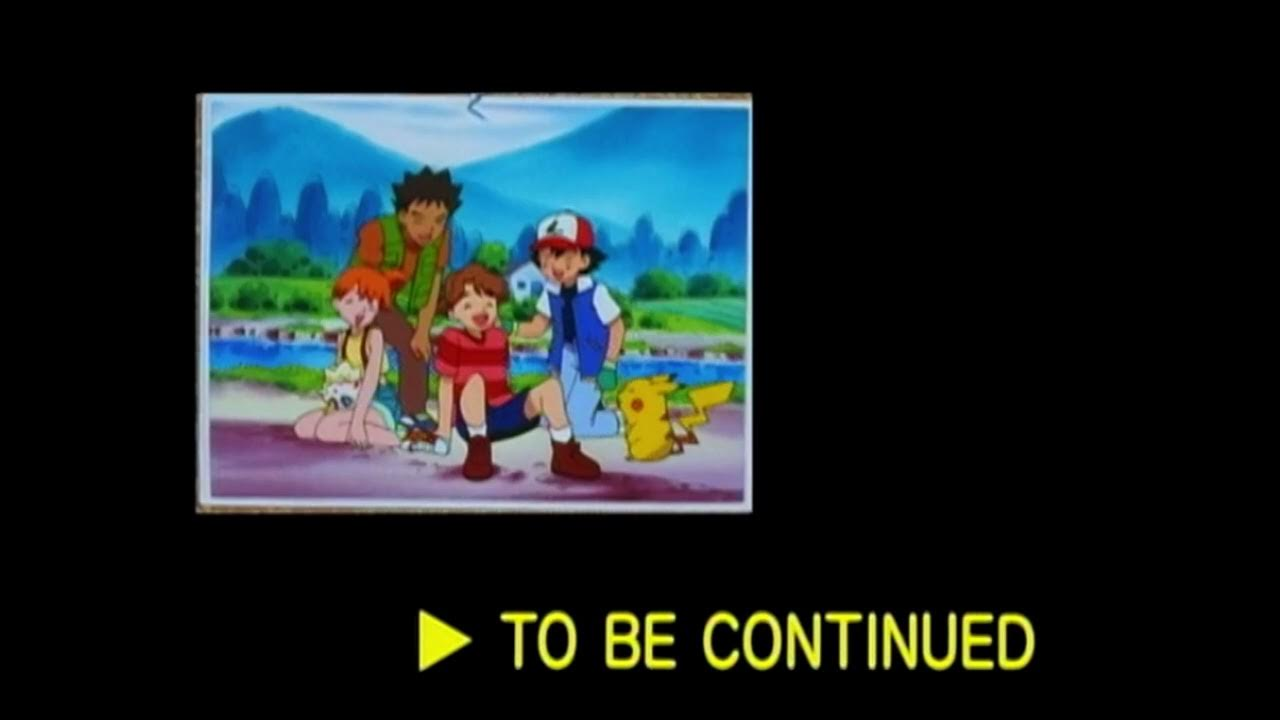